In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary

pyro.set_rng_seed(1)

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

<AxesSubplot:>

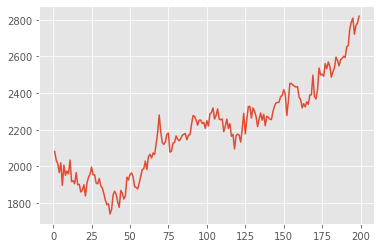

In [2]:
### Specifying SES as State Space Model

initial_level, smoothing_level = 2000, 0.8

ys = [None for i in range(200)]
ls = [None for i in range(200)]
ls[0] = initial_level

for i in range(1, 200):
    
    noise = np.random.normal(0, 50)
    ys[i] = ls[i-1] + noise
    ls[i] = ls[i-1] + smoothing_level * noise

d = pd.DataFrame({'y': ys, 'level': ls})

d['y_lag-1'] = d.y.shift(-1)

d.y.plot()

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [ ]:
dist.Uniform

In [ ]:
pyro.plate

In [28]:
def ses_model(ys, y_lags):
    initial_level = pyro.sample(f'initial_level', dist.Uniform(0, 20000))
    smoothing_level = pyro.sample(f'smoothing_level', dist.Uniform(0, 1))
    
    levels = [1.0 for i in range(len(ys))]
    levels[0] = initial_level
    
    for i in range(1, len(ys)):
        levels[i] = smoothing_level*(ys[i]) + (1 - smoothing_level)*(levels[i-1])
        
    y_hats = torch.tensor(levels[:-1])
        
    sigma = pyro.sample(f'sigma', dist.Uniform(0, 400))
    with pyro.plate("data", len(ys)-1):
        pyro.sample("obs", dist.Normal(y_hats, sigma), obs=y_lags)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d.iloc[:-1, :]['y_lag-1'])

In [12]:
d.head(2)

,y,level,y_lag-1
0,NaN,2000.000000,2081.217268
1,2081.217268,2064.973815,2034.385994


In [20]:
ys = torch.tensor(d.y)
y_lags = torch.tensor(d.iloc[:-1, :]['y_lag-1'])

In [29]:
nuts_kernel = NUTS(ses_model, jit_compile=False, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel,
            num_samples=200,
            warmup_steps=100,
            num_chains=1)
mcmc.run(ys, y_lags)
samples = mcmc.get_samples()

Warmup:  19%|█▉        | 57/300 [05:15,  6.14s/it, step size=4.33e-04, acc. prob=0.749]

KeyboardInterrupt: 

In [ ]:
nuts_kernel = NUTS(not_pooled, jit_compile=args.jit, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel,
            num_samples=args.num_samples,
            warmup_steps=args.warmup_steps,
            num_chains=args.num_chains)
mcmc.run(at_bats, hits)
samples_not_pooled = mcmc.get_samples()
logging.info("\nModel: Not Pooled")
logging.info("=================")
logging.info("\nphi:")
logging.info(get_summary_table(mcmc.get_samples(group_by_chain=True),
                               sites=["phi"],
                               player_names=player_names,
                               diagnostics=True,
                               group_by_chain=True)["phi"])
num_divergences = sum(map(len, mcmc.diagnostics()["divergences"].values()))
logging.info("\nNumber of divergent transitions: {}\n".format(num_divergences))
sample_posterior_predictive(not_pooled, samples_not_pooled, baseball_dataset)
evaluate_pointwise_pred_density(not_pooled, samples_not_pooled, baseball_dataset)

In [5]:
init_params, potential_fn, transforms, _ = initialize_model(
        ses_model, model_args=(d), num_chains=4,
        jit_compile=False, skip_jit_warnings=True)

TypeError: ses_model() takes 1 positional argument but 3 were given

In [ ]:
init_params, potential_fn, transforms, _ = initialize_model(
        fully_pooled, model_args=(at_bats, hits), num_chains=args.num_chains,
        jit_compile=args.jit, skip_jit_warnings=True)
nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            num_samples=args.num_samples,
            warmup_steps=args.warmup_steps,
            num_chains=args.num_chains,
            initial_params=init_params,
            transforms=transforms)
mcmc.run(at_bats, hits)
samples_fully_pooled = mcmc.get_samples()
logging.info("\nModel: Fully Pooled")
logging.info("===================")
logging.info("\nphi:")
logging.info(get_summary_table(mcmc.get_samples(group_by_chain=True),
                               sites=["phi"],
                               player_names=player_names,
                               diagnostics=True,
                               group_by_chain=True)["phi"])
num_divergences = sum(map(len, mcmc.diagnostics()["divergences"].values()))
logging.info("\nNumber of divergent transitions: {}\n".format(num_divergences))
sample_posterior_predictive(fully_pooled, samples_fully_pooled, baseball_dataset)
evaluate_pointwise_pred_density(fully_pooled, samples_fully_pooled, baseball_dataset)

In [ ]:
# is the levels concatentation less of a pain?
# can we do loops efficiently without theano.scan?
# can if x > y work?

# if above isnt easy, maybe we just break the code up in pymc3 so that we don't need the "if"
# also, twiecki mentioned they care more about inference in pymc3 and so that inference is faster. what's he mean? prediction vs inference? ah, inferring effects of features vs just accurate predictions

In [296]:
with pm.Model() as ses_model:
#     initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000, shape=(1,1))
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    
    # move this out? or use scan? does this create unnecessary var's?
#     levels = [1.0 for i in range(len(d))]
#     levels[0] = initial_level
    
    # move this out? or use scan? does this create unnecessary var's?
#     for i in range(1, len(d)):
# #         levels[i] = pm.Deterministic(f'level_{i}',smoothing_level*(d.loc[i]['y']) \
# #                                      + (1 - smoothing_level)*(levels[i-1]))
#         levels[i] = smoothing_level*(d.loc[i]['y']) + (1 - smoothing_level)*(levels[i-1])

    ys = d['y']
    
    levels, updates = theano.scan(fn = lambda y, prior_level: smoothing_level * y + (1 - smoothing_level) * prior_level,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
#                dict(initial = pm.math.floatX(ls[0]), taps=None)
               dict(initial = initial_level, taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )

    # Y(t+1) = L(t)
#     y_hats = np.array(levels[:-1])
#     y_hats = tt.as_tensor_variable(levels[:-1])
    y_hats = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
#     y_hats = levels[:-1]
    
#     levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
#     levels_plus_slopes = levels_and_slopes.sum(axis=0)
#     levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
#     y_hats = levels_slopes_seasons.prod(axis=0)
    
    sigma = pm.Uniform('sigma', lower=0, upper=400)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d.iloc[:-1, :]['y_lag-1'])

WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
